In [87]:
import numpy as np

from csxtools.utils import get_fastccd_images,get_images_to_3D, get_images_to_4D, get_fastccd_flatfield
from csxtools.ipynb import image_stack_to_movie, show_image_stack

from matplotlib import pyplot as plt
import skbeam.core.correlation as corr
import skbeam.core.roi as roi
import matplotlib.patches as patches

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact

import time
import pandas as pd 

In [3]:
from databroker import Broker
db = Broker.named('csx',auto_register =  False)

In [32]:
pwd

'/nsls2/users/abarbour'

## Use the next line to get into your home directory, which is not /nsls2
See your current home directory above

In [33]:
cd /home/abarbour

/home/abarbour


118524 636.0
141789 638.0
[118522, 118524, 141789]
add 2 eV to previous Ei: for 2021-1 625 and 635
XAS with FCCD is raw ADU without gain correction.  Need to process images to see true XAS of scattering ring.


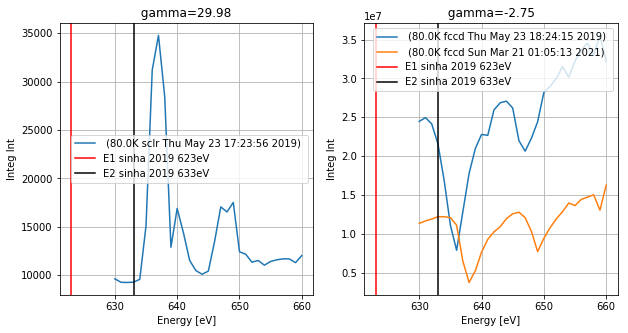

In [105]:
used_scans = []

roi = '4'
#'slt3 foc 50um, double pinholes' --> 141785
#'slt3 foc 2mm, double pinholes',  --> 141787, 141788,
hhs = db[118522,118524,   141789 ]
mults = [1, 1 , 1e-1]
descipt = ['multi-target', 'chamber foc',   'slt3 foc 50um, sample pinhole']
fig, axes = plt.subplots(1,2, figsize=(10,5))
for h, mult in zip(hhs, mults):
    tbl = h.table()
    #Tsample = h.table('baseline')["stemp_temp_B_T"].mean()
    Tcntrl = h.table('baseline')["stemp_temp_A_T"].mean()
    gamma = h.table('baseline')['tardis_gamma'].mean()
    if gamma > 0 :
        ax = axes[0]
        y = tbl['sclr_ch2']
        detect = 'sclr'
    elif gamma < 0:
        ax = axes[1]
        y = tbl['fccd_stats'+roi+'_total']
        detect = 'fccd'
        print(h.start["scan_id"], x[y.idxmin()])

    else:
        raise
    x = tbl.pgm_energy_setpoint
    #
    
    #H = Q[0] - 0.155
    #dK = Q[1] - 0.155 
    #dHK = (dH+dK)/2
    date = time.ctime(h.start["time"])
    ax.set_title(f' gamma={gamma:.2f} ')
    ax.plot(x, y*mult, label=f' ({Tcntrl:.1f}K {detect} {date}) ')
    ax.legend(loc=4)
    #ax.set_ylim()
    ax.grid(True)
    ax.set_xlabel('Energy [eV]')
    ax.set_ylabel('Integ Int')
    

    used_scans.append(h.start["scan_id"])
print(used_scans)
for ax in axes:
    ax.axvline(623, c='r', label='E1 sinha 2019 623eV')
    ax.axvline(633, c='k', label='E2 sinha 2019 633eV')
    ax.legend()
    
print(f'add 2 eV to previous Ei: for 2021-1 {623+2} and {633+2}')
print('XAS with FCCD is raw ADU without gain correction.  Need to process images to see true XAS of scattering ring.')

In [19]:
info = h.start["sample"]['composition']+'_'+h.start["sample"]['type']

Text(0,0.5,'Temperature deviation from average [K]')

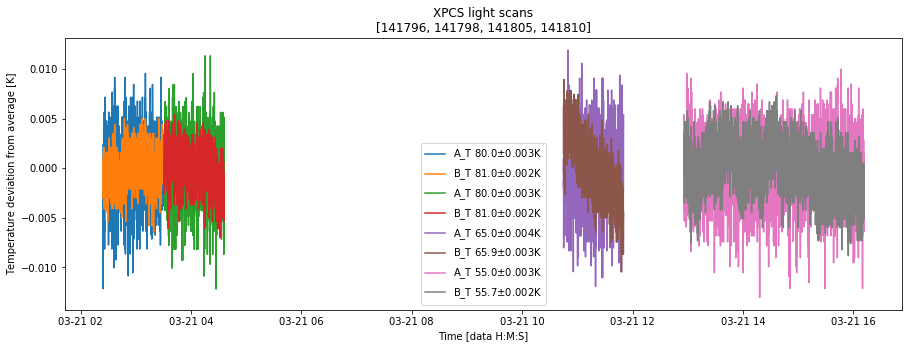

In [27]:
xpcs_light_scans = [141796, 141798, 141805, 141810]
monitors = ['stemp_temp_A_T_monitor','stemp_temp_B_T_monitor']
plt.figure(figsize=(15, 5))
for s in xpcs_light_scans:
    h = db[s]
    for m in monitors:
        t = h.table(m)
        avg = t[m[:-8]].mean()
        sd = t[m[:-8]].std()
        plt.plot(t.time, t[m[:-8]]-t[m[:-8]].mean(), label = f'{m[11:-8]} {avg:.1f}$\pm${sd:.3f}K')
plt.legend()
plt.title(f'XPCS light scans\n{xpcs_light_scans}')
plt.xlabel('Time [data H:M:S]')
plt.ylabel('Temperature deviation from average [K]')

Text(0,0.5,'Intensity variation [ADU (no gain correction)]')

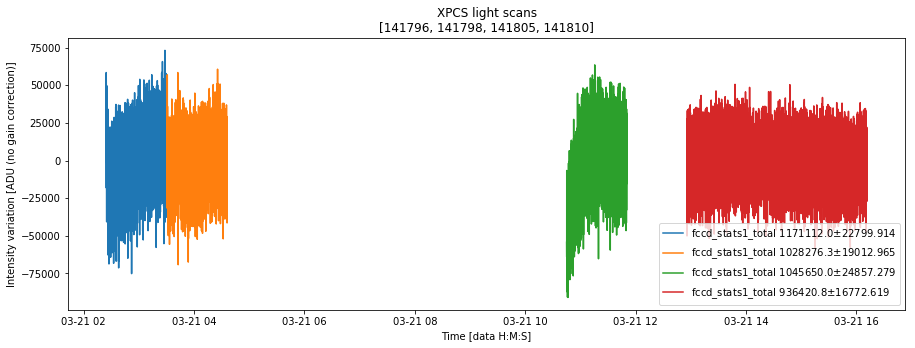

In [98]:

xpcs_light_scans = [141796, 141798, 141805, 141810]
monitors = ['fccd_stats1_total_monitor',]
plt.figure(figsize=(15, 5))
for s in xpcs_light_scans:
    h = db[s]
    for m in monitors:
        t = h.table(m)
        avg = t[m[:-8]].mean()
        sd = t[m[:-8]].std()
        plt.plot(t.time, t[m[:-8]]-t[m[:-8]].mean(), label = f'{m[:-8]} {avg:.1f}$\pm${sd:.3f}')
plt.legend()
plt.title(f'XPCS light scans\n{xpcs_light_scans}')
plt.xlabel('Time [data H:M:S]')
plt.ylabel('Intensity variation [ADU (no gain correction)]')

## Load archiver data from file

In [36]:
data = np.load('scans_141780-141814_cryostat_info_sampleTb.npy', allow_pickle=True).tolist()
print(data.keys())
print(data["sampleTa"].keys())

dict_keys(['sampleTa', 'sampleTb'])
dict_keys(['seconds', 'time', 'pvdata', 'rawtimes'])


## Plot against archiver data
- note the 4 hours subtracted from archiver data

Text(0,0.5,'Temperature [K]')

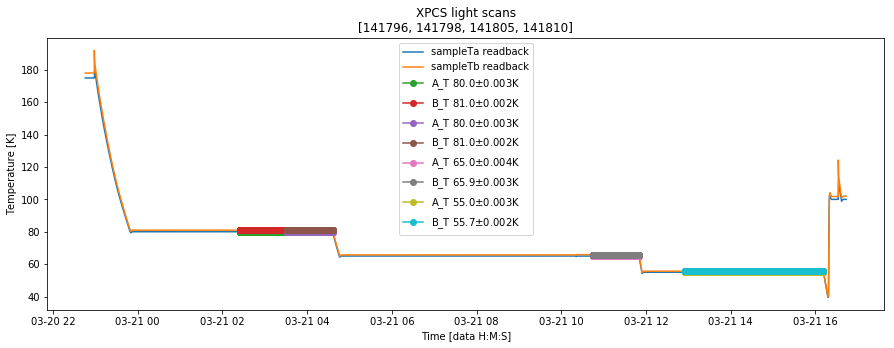

In [96]:
plt.figure(figsize=(15, 5))
for k in data.keys():
    df = pd.DataFrame.from_dict(data[k])
    #x = df['time'] #need to change timezone
    x = pd.to_datetime(df['seconds']-(4*3600),unit= 's') #correction of 4 hours
    y = df['pvdata'] 
    plt.plot(x,y, label=f'{k} readback')

monitors = ['stemp_temp_A_T_monitor','stemp_temp_B_T_monitor']

for s in xpcs_light_scans:
    h = db[s]
    for m in monitors:
        t = h.table(m)
        avg = t[m[:-8]].mean()
        sd = t[m[:-8]].std()
        plt.plot(t.time, t[m[:-8]], 'o-', label = f'{m[11:-8]} {avg:.1f}$\pm${sd:.3f}K')
plt.legend()
plt.title(f'XPCS light scans\n{xpcs_light_scans}')
plt.xlabel('Time [data H:M:S]')
plt.ylabel('Temperature [K]')

